# 2. CNN (Done in colab) https://www.robots.ox.ac.uk/~vgg/data/pets/

In [2]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (256, 256)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
        and fname[0] != fname[0].lower()
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
        and fname[0] != fname[0].lower()
    ]
)

print("Number of samples:", len(input_img_paths))

Number of samples: 2400


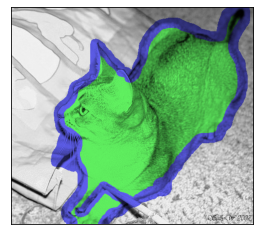

In [3]:
from skimage import data, color, io, img_as_float
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img


def plot_masked_image(image, mask):
  alpha = 0.6

  img = img_as_float(image)
  rows, cols,_ = img.shape

  color_mask = np.zeros((rows, cols, 3))
  color_mask[mask==2] = [0, 0, 0] 
  color_mask[mask==1] = [0, 1, 0] 
  color_mask[mask==3] = [0, 0, 1] 

  img_hsv = color.rgb2hsv(img)
  color_mask_hsv = color.rgb2hsv(color_mask)

  img_hsv[..., 0] = color_mask_hsv[..., 0]
  img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

  img_masked = color.hsv2rgb(img_hsv)

  f, ax = plt.subplots(subplot_kw={'xticks': [], 'yticks': []})

  ax.imshow(img_masked)
  plt.show()

plot_masked_image(np.array(load_img(input_img_paths[9])), np.array(load_img(target_img_paths[9]))[:,:,0])

In [4]:
from tensorflow import keras


class ImageGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            y[j] -= 1
        return x, y


In [5]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Train-test split images

In [6]:
import random

# Split our img paths into a training and a validation set
val_samples = 400
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = ImageGenerator(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = ImageGenerator(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [7]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/15
62/62 [==============================] - 35s 561ms/step - loss: 1.6111 - val_loss: 1.1662
Epoch 2/15
62/62 [==============================] - 36s 576ms/step - loss: 0.7762 - val_loss: 1.9946
Epoch 3/15
62/62 [==============================] - 35s 567ms/step - loss: 0.6522 - val_loss: 1.9794
Epoch 4/15
62/62 [==============================] - 35s 568ms/step - loss: 0.5789 - val_loss: 2.7979
Epoch 5/15
62/62 [==============================] - 35s 569ms/step - loss: 0.5153 - val_loss: 2.5211
Epoch 6/15
62/62 [==============================] - 35s 568ms/step - loss: 0.4636 - val_loss: 1.3862
Epoch 7/15
62/62 [==============================] - 35s 569ms/step - loss: 0.4282 - val_loss: 1.7956
Epoch 8/15
62/62 [==============================] - 35s 569ms/step - loss: 0.3954 - val_loss: 0.8048
Epoch 9/15
62/62 [==============================] - 35s 567ms/step - loss: 0.3634 - val_loss: 0.5328
Epoch 10/15
62/62 [==============================] - 35s 568ms/step - loss: 0.3362 - val_lo

## Results

Ground Truth


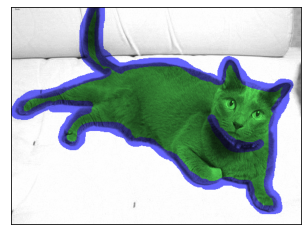

Prediction


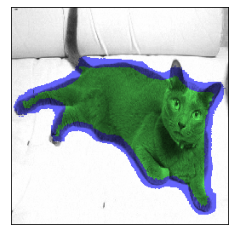

In [10]:
val_gen = ImageGenerator(1, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

i = 7
print('Ground Truth')
plot_masked_image(load_img(val_input_img_paths[i]), np.array(load_img(val_target_img_paths[i]))[:,:,0])
print('Prediction')
plot_masked_image(np.array(val_gen[i][0][0], dtype='uint8'), np.argmax(val_preds[i], axis=-1)+1)